# Tutorial 2: Entanglement Forging with Quantum Serverless
**March 02, 2023 <br/>**
**For SCA2023: Future of HPC with Quantum Workshop<br>**
This tutorial was generated from [Circuit Knitting toolbox docs](https://github.com/Qiskit-Extensions/circuit-knitting-toolbox/blob/main/docs/tutorials/entanglement_forging/) and [Quantum Serverless docs](https://github.com/Qiskit-Extensions/quantum-serverless/tree/main/docs)

**Entanglement forging** is a method which allows us to represent expectation values of a 2n-qubit wavefunction as sums of multiple expectation values of n-qubit states, embedded in a classical optimization, thus doubling the size of the system that can be exactly simulated with a fixed number of qubits.

See [Tutorial 1](https://github.com/Qiskit-Extensions/circuit-knitting-toolbox/blob/main/docs/tutorials/entanglement_forging/tutorial_1_getting_started.ipynb) for a high-level breakdown of the entanglement forging algorithm, or check out the [explanatory material](https://github.com/Qiskit-Extensions/circuit-knitting-toolbox/blob/main/docs/explanation/entanglement_forging/index.rst) for a more detailed explanation.

### Adapting entanglement forging for use with `Quantum Serverless`

[**Quantum Serverless**](https://github.com/Qiskit-Extensions/quantum-serverless) is a platform built to enable distributed computing across a variety of classical and quantum backends.

In this demo, we will show how to configure a ground state workflow with entanglement forging and seamlessly adapt it to run entirely on the cloud using Quantum Serverless.

<img src="images/forging_with_serverless.png" width = 50%>

### Instantiate the `ElectronicStructureProblem`

For this tutorial, we will model a system in which H2O is split on a magnesium surface, as described in **Fig. 1(a)** from [arXiv:2203.07536](https://arxiv.org/abs/2203.07536). In particular, we'll compute the ground state energy of the reactant in this reaction. Entanglement forging reduces the total number of qubits needed from 4 to 2.

<img src="images/mg_structure.png" width = 50%>

Here we read in the system information, populate an `IntegralDriver` object from `Circuit Knitting Toolbox`, and use that driver to instantiate an `ElectronicStructureProblem` from Qiskit.

## Entanglement forging overview

Entanglement forging [2] was introduced as a way to reduce the number of qubits necessary to perform quantum simulation of chemical or physical systems. In general, to simulate n orbitals in a chemistry problem, one typically needs 2n qubits. Entanglement Forging makes it possible to represent expectation values of a 2n-qubit wavefunction as sums of multiple expectation values of n-qubit states, embedded in a classical computation, thus doubling the size of the system that can be exactly simulated with a fixed number of qubits.

Furthermore, Entanglement Forging permits the circuits necessary for the n-qubit simulations to be shallower, relaxing requirements on gate error and connectivity, at the cost of increased quantum and classical run times.

The schematic below outlines how the expectation value M of a 2n-qubit wavefunction |ψ>2n with respect to a 2n-qubit Hamiltonian H2n can be decomposed into a sum of expectation values of products of n-qubit wavefunctions with respect to n-qubit operators. These n-qubit expectation values correspond to sub-experiments.

<img src="images/forging_info_graphic.png" width = 70%>

1. **Decompose**:
    * Decompose the 2n-qubit ansatz (wavefunction) into many parameterized, n-qubit ansatze
    * Decompose the 2n-qubit observable (Hamiltonian) into many n-qubit observables


2. **Evaluate**:
    * Use the n-qubit expectation values to reconstruct an estimation of the original 2n-qubit expectation value
  
  
3. **Reconstruct** 
    * Use the expectation values to reconstruct an estimation of the expectation value for the 2n-qubit system
  
  
4. **If the expectation value (energy) has not converged, update the ansatze parameters and continue with Step 2**

### Instantiate the `ElectronicStructureProblem`

For this tutorial, we will model a system in which H2O is split on a magnesium surface, as described in Fig. 1(a) from [arXiv:2203.07536](https://arxiv.org/abs/2203.07536). In particular, we'll compute the ground state energy of the reactant in this reaction. Entanglement forging reduces the total number of qubits needed from 4 to 2.

Here we read in the system information, populate an `IntegralDriver` object from `Circuit Knitting Toolbox`, and use that driver to instantiate an `ElectronicStructureProblem` from Qiskit.

In [2]:
from pathlib import Path
import numpy as np
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from circuit_knitting_toolbox.utils import IntegralDriver

system_data = np.load("reactant_2mo.npz")
num_molecular_orbitals = 2

driver = IntegralDriver(
    hcore=system_data["h1"],
    mo_coeff=system_data["HF_mo_coeff"],
    eri=system_data["Gamma_eri"],
    num_alpha=system_data["na"],
    num_beta=system_data["nb"],
    nuclear_repulsion_energy=system_data["h0"],
)

problem = ElectronicStructureProblem(driver)

### Configure the entanglement forging specific inputs

The ansatz for Entanglement Forging consists of a set of input bitstrings and a parameterized circuit.  (See the [explanatory material](https://github.com/Qiskit-Extensions/circuit-knitting-toolbox/blob/main/docs/explanation/entanglement_forging/index.rst) for additional background on the method). For this demo, we will use the same bitstrings and ansatz for both the U and V subsystems, and we will use the [TwoLocal](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html) circuit from Qiskit, along with [hop gates](https://doi.org/10.1103/PRXQuantum.3.010309).

Hop gate:



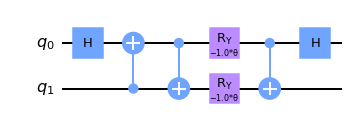

In [3]:
from qiskit.circuit import QuantumCircuit, Parameter

theta = Parameter("θ")

hop_gate = QuantumCircuit(2, name="hop_gate")
hop_gate.h(0)
hop_gate.cx(1, 0)
hop_gate.cx(0, 1)
hop_gate.ry(-theta, 0)
hop_gate.ry(-theta, 1)
hop_gate.cx(0, 1)
hop_gate.h(0)

print(f"Hop gate:\n")
hop_gate.draw(output="mpl")

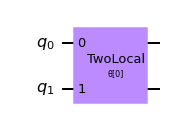

In [4]:
from qiskit.circuit.library import TwoLocal
from circuit_knitting_toolbox.entanglement_forging import EntanglementForgingAnsatz

entangler_map = [[0, 1]]
bitstrings_u = [(1, 0), (0, 1)]

circuit_u = TwoLocal(num_molecular_orbitals, [], hop_gate, entangler_map, reps=1)
ansatz = EntanglementForgingAnsatz(
    circuit_u=circuit_u,
    bitstrings_u=bitstrings_u,
)
ansatz.circuit_u.draw("mpl")

### Set up the Qiskit Runtime Service

The Qiskit Runtime Service provides access to Qiskit Runtime Primitives and quantum backends. See the [Qiskit Runtime documentation](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/) for more information.  Here, we specify the backend(s) to be used to evaluate the circuits. Backends could be [simulator(s) and/or quantum device(s)](https://quantum-computing.ibm.com/services/resources?tab=systems).

Alternatively, if a Qiskit Runtime Service is not passed, then a local simulator will be used with the [Qiskit Primitives](https://qiskit.org/documentation/apidoc/primitives.html), and the `backend_names` argument will be ignored.

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService, Options

# Uncomment the following line to instead use the Qiskit Runtime Service.
service = QiskitRuntimeService(channel="ibm_quantum")

# By default, use a local simulator to implement the Qiskit Runtime Primitives
# service = None

backend_names = ["ibmq_qasm_simulator"] * 2
# backend_names = [["ibmq_lima"],["ibmq_manila"]]

# If a single set of options are passed, it will be applied to all backends
options = [Options(execution={"shots": 1000}), Options(execution={"shots": 2000})]

### Set up Quantum Serverless

We can use Quantum Serverless to send the entanglement forging routine to a remote compute resource. For this tutorial, we will use our local CPU cores as the compute cluster. See the [Quantum Serverless](https://github.com/Qiskit-Extensions/quantum-serverless) documentation (and below) for more information about how to use other clusters.

**Compute resources**

Compute resources can be described as set of computational nodes with resources associated to each of them.
Nodes are performing computation itself. 
Distributed storage is for accessing sharable resources between nodes.

![compute resources](https://raw.githubusercontent.com/Qiskit-Extensions/quantum-serverless/main/docs/tutorials/images/diagrams_compute_resource.png)


In order to resolve distributed compute we need a way to orchestrate our workloads on remote resources.

**Object**

Let's first look how to turn a local object into a remote one.

To turn your local object to distributed one you need to call `put` function. 
It will serialize your object and send it to distributed storage and return you a reference to remote object location. 

![objects diagram](https://raw.githubusercontent.com/Qiskit-Extensions/quantum-serverless/main/docs/tutorials/images/diagrams_put.png)

Example

```python
cirucit = QuantumCircuit(N, M)
...
circuit_reference = quantum_serverless.put(circuit)
```

Now we know how to move local object to remote compute resource. 
Next we need to do something with it. For this we will have remote functions.

**Functions**

As a second step we need to know how to transform our local function into remote one. 

In order to do that you need to annotate function with `run_qiskit_remote` decorator. 
This will turn your function into remote executable.  

![functions diagram](https://raw.githubusercontent.com/Qiskit-Extensions/quantum-serverless/main/docs/tutorials/images/diagrams_function.png)

All you need to do now is call this function and it will be executed as a remote procedure automatically. 

If you run N instances of this function in parallel you need just call it N times in a loop. 
The result of the following code will be a list of references to execution results.

Example

```python
@quantum_serverless.run_qiskit_remote()
def exp_val_remote(cirucit, obs):
    estimator = Estimator(...)
    return estimator.run(circuit, obs)

obs: Operator = ...

exp_val_execution_reference = exp_val_remote(circuit, obs)

circuit_list: List[QuantumCircuit] = [...]

obs_ref = quantum_serverless.put(obs)

exp_val_execution_references = [
    exp_val_remote(circ, obs_ref) 
    for circ in circuit_list
]
```

As you can see we are passing an observable by refernce and circuits by values. Attributes passed by value will be converted to remote objects automatically and resolved within the remote function. We are passing observable by referece because we know it is the same one shared by all parallel function invocations, so we are saving some space. 

**Collecting results**

And of course you need to collect your results back from remote resources. 
In order to do that you need to call the `get` function, which can be applied to object and function references or, alternatively, to a list of references.

![collecting results diagram](https://raw.githubusercontent.com/Qiskit-Extensions/quantum-serverless/main/docs/tutorials/images/diagram_get.png)

Example

```python
collected_circuit = quantum_serverless.get(circuit_reference)
# <QuantumCircuit ...>

collected_exp_value = quantum_serverless.get(exp_val_execution_reference)
# <EstimatorResult ...>
collected_exp_values = quantum_serverless.get(exp_val_execution_references)
# [<EstimatorResult ...>, <EstimatorResult ...>, ...]
```

**Resource allocation**

Some functions are more demanding than others. 
To allocate specific resources to a function, the decorator accepts `target` parameter.
For example, your function may require 2 cpus to be executed. You can pass `target={'cpu': 2}` to decorator and this function will request 2 cpus from your resource capacity to be executed.

![resource allocation diagram](https://raw.githubusercontent.com/Qiskit-Extensions/quantum-serverless/main/docs/tutorials/images/diagrams_resource_allocation.png)

Example

```python
@quantum_serverless.run_qiskit_remote(target={"cpu": 2, "mem": 8})
def exp_val_remote(cirucit, obs):
    estimator = Estimator(...)
    exp_val_result = estimator.run(circuit, obs)
    ...
    return result
```

**Execution management**

Now we figured how to convert our function and objects into remote counterparts and how to request for specific resources.
Next step would be deciding where to run your workloads. 

To have control over location of compute we use configurations in `QuantumServerless` object and python context managers. 

`QuantumServerless` has a notion of `providers` which are abstractions to define where your compute resources are located.

By default you always have a `local` provider which is your local machine where nodes and local cores.
And you can configure as many providers as you want.

![execution management diagram](https://raw.githubusercontent.com/Qiskit-Extensions/quantum-serverless/main/docs/tutorials/images/diagrams_context_management.png)

Example

```python
serverless = QuantumServerless({"providers": [...]})
serverless = QuantumServerless.load_configuration("<PATH_TO_CONFIG_FILE>")
print(serverless)
# <QuantumServerless: providers [local, ibm-cloud, ...]>

with serverless.context("local"):
    exp_val_execution_reference = exp_val_remote(circuit, obs)
    collected_exp_value = quantum_serverless.get(exp_val_execution_reference)

with serverless.context("ibm-cloud"):
    exp_val_execution_reference = exp_val_remote(circuit, obs)
    collected_exp_value = quantum_serverless.get(exp_val_execution_reference)
```

In [6]:
from quantum_serverless import QuantumServerless

serverless = QuantumServerless()
serverless.providers()

[<Provider: local>]

### Create a wrapper function to send to the remote cluster

Use Quantum Serverless to send the `solve_remote` method to a remote cluster.

Here we create a wrapper function for `EntanglementForgingGroundStateSolver` and its `solve` method, and we annotate it with the `@run_qiskit_remote()` decorator from Quantum Serverless. This allows us to call this function from a serverless context and have it sent for remote execution on the specified cluster.

In [7]:
from typing import Optional, Sequence, Tuple, Dict, Union
from qiskit.algorithms.optimizers import Optimizer
from qiskit.result import Result
from quantum_serverless import run_qiskit_remote
from circuit_knitting_toolbox.entanglement_forging import (
    EntanglementForgingGroundStateSolver,
)


@run_qiskit_remote(target={"cpu": 2})
def solve_remote(
    problem: ElectronicStructureProblem,
    ansatz: EntanglementForgingAnsatz,
    optimizer: Optimizer,
    service_args: Optional[Dict] = None,
    backend_names: Optional[Union[str, Sequence[str]]] = None,
    options_dicts: Optional[Union[Dict, Sequence[Dict]]] = None,
    initial_point: Optional[Sequence[float]] = None,
    orbitals_to_reduce: Optional[Sequence[int]] = None,
) -> Result:
    """
    Wrapper function for running entanglement forging VQE on a remote resource.

        Args:
            - problem: A class encoding the problem to be solved
            - ansatz: The ansatz
            - optimizer: Optimizer to use to optimize the ansatz circuit parameters
            - service_args: The arguments for instantiating a QiskitRuntimeService
            - backend_names: List of backend names to use during parallel computation
            - options_dicts: Options to use with backends
            - initial_point: Initial values for ansatz parameters
            - orbitals_to_reduce: List of orbital indices to remove from the problem before
                decomposition.
        Returns:
            - An interpreted EigenstateResult
    """
    service = QiskitRuntimeService(**service_args) if service_args else None

    # Convert options dictionaries into Options objects
    options = None
    if options_dicts:
        if isinstance(options_dicts, Dict):
            options_dicts = [options_dicts]
        options = [Options(**o) for o in options_dicts]

    solver = EntanglementForgingGroundStateSolver(
        ansatz=ansatz,
        service=service,
        optimizer=optimizer,
        backend_names=backend_names,
        options=options,
        initial_point=initial_point,
        orbitals_to_reduce=orbitals_to_reduce,
    )
    result = solver.solve(problem)

    return result

### Run entanglement forging on a remote cluster

Once a user has set up their `ElectronicStructureProblem`, `EntanglementForgingAnsatz`, and other program options, the only thing remaining is call `EntanglementForgingGroundStateSolver.solve`, which we have wrapped in the `solve_remote` function.

We will call the `solve_remote` function within a QuantumServerless context, which means it will be run on the specified cluster. Remember, the default cluster for this demo will use the cores on our local CPU. To specify a new cluster, the `QuantumServerless.set_provider` method should be used.

When the remote function is called, it will return a "future" object, and Python will continue interpreting the next line of code. The `get` function is a blocking command which should be used to retrieve the results of the remote function via the "future" object. The program will not continue past the `get` call until the results of the remote function are returned.

In [8]:
%%capture
from dataclasses import asdict
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA
from quantum_serverless import get

optimizer = COBYLA(maxiter = 100)

# QiskitRuntimeService is not serializable, so we must convert it to a dictionary before passing to remote function
service_args = None if service is None else service.active_account()

# The Options class is not serializable, so we must convert it to a dictionary before passing to remote function
options_dicts = [asdict(o) for o in options]

# serverless.set_provider("aws") or serverless.set_provider("ibm") or serverless.set_provider("azure")
with serverless:
    forging_result_future = solve_remote(
        problem,
        ansatz,
        optimizer,
        service_args=service_args,
        backend_names=backend_names,
        options_dicts=options_dicts,
    )
    results = get(forging_result_future)

#### Optional: Guide to multi cloud deployment 

The guide here shows you step by step how to deploy these resources to be able to load and use that client with your desired configuration https://github.com/Qiskit-Extensions/quantum-serverless/blob/main/docs/guides/08_multi_cloud_deployment.rst

In [13]:
# Configuration constructor arguments example
# serverless = QuantumServerless({
#     "providers": [{
#         "name": "Sca2023_provider",  # provider name
#         "compute_resource": { # main computational resource
#             "name": "my_resource", # cluster name
#             "host": "HOST_ADDRESS_OF_CLUSTER_HEAD_NODE", # cluster host address, if you are using helm it will be DEPLOYMENT_NAME-kuberay-head-svc
#         }
#     }]
# })

# Other option will be creating an instance from configuration file, which has exactly the same structure as example above.
#
# serverless = QuantumServerless.load_configuration("./serverless_config.json")

#### Optional: Running as an async script
In most of the cases we want to run our scripts as async programs, so we can lunch them and forget, then later on check results. In order to do so we will use Program interface.


In [7]:
# from quantum_serverless import Program
#
# program = Program(
#     name="awesome_program",
#     entrypoint="some_program.py",
#     working_dir=""./source_files/"",
#     description="description of a program",
#     version="0.0.1"
# )
#
# job = serverless.run_program(program)
# job

<Job | fqs_9ae47383-3c21-41ab-84f6-61a969a68b06>


### Visualize the results

Visualize the convergence of the estimated ground state energy and the Schmidt coefficients as the ansatz parameters are optimized.

Energy:


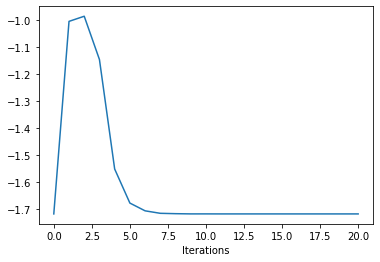

Schmidt Coefficients:


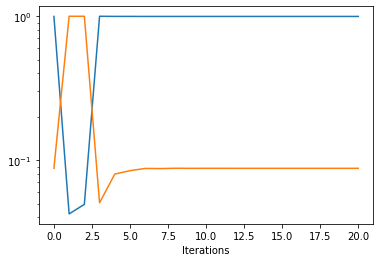

Parameters:


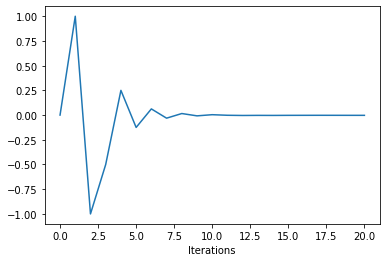

In [9]:
import matplotlib.pyplot as plt

print("Energy:")
plt.plot([evaluation.eigenvalue for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

print("Schmidt Coefficients:")
plt.plot([abs(evaluation.eigenstate) for evaluation in results.history])
plt.xlabel("Iterations")
plt.yscale("log")
plt.show()

print("Parameters:")
plt.plot([evaluation.parameters for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

In [41]:
import qiskit.tools.jupyter

%qiskit_version_table

### This code is a Qiskit project.

© Copyright IBM 2022.

This code is licensed under the Apache License, Version 2.0. You may
obtain a copy of this license in the LICENSE.txt file in the root directory
of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.

Any modifications or derivative works of this code must retain this
copyright notice, and modified files need to carry a notice indicating
that they have been altered from the originals.